In [1]:
# === Cell 1: Load data dan fitur terpilih ===

import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

# Load data hasil preprocessing
X_scaled = pd.read_csv("../data/processed/X_scaled.csv", dtype="float32")
y = pd.read_csv("../data/processed/y.csv", dtype="int8").squeeze()

# Load daftar fitur terpilih
with open("../data/processed/selected_features.json") as f:
    selected_features = json.load(f)

# Ambil hanya kolom fitur terpilih
X_selected = X_scaled[selected_features]

print(f"Jumlah fitur terpilih: {len(selected_features)}")
print(f"Shape data lengkap: {X_selected.shape}")
print(f"Distribusi label: {y.value_counts().to_dict()}")


Jumlah fitur terpilih: 30
Shape data lengkap: (2768674, 30)
Distribusi label: {1: 2242880, 0: 525794}


In [2]:
# === Cell 2: Split data train/val/test ===

X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (1771951, 30), Val: (442988, 30), Test: (553735, 30)


In [3]:
# === Cell 3: Train model LightGBM ===

from lightgbm import LGBMClassifier, early_stopping

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss",
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

print("✅ Training selesai")


[LightGBM] [Info] Number of positive: 1435443, number of negative: 336508
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.323417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6512
[LightGBM] [Info] Number of data points in the train set: 1771951, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810092 -> initscore=1.450607
[LightGBM] [Info] Start training from score 1.450607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.0011987
✅ Training selesai


In [4]:
# === Cell 4: Evaluasi dasar ===

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.9999843791535619

Classification Report:
               precision    recall  f1-score   support

           0     0.9986    0.9995    0.9990    105159
           1     0.9999    0.9997    0.9998    448576

    accuracy                         0.9996    553735
   macro avg     0.9992    0.9996    0.9994    553735
weighted avg     0.9996    0.9996    0.9996    553735


Confusion Matrix:
 [[105102     57]
 [   150 448426]]


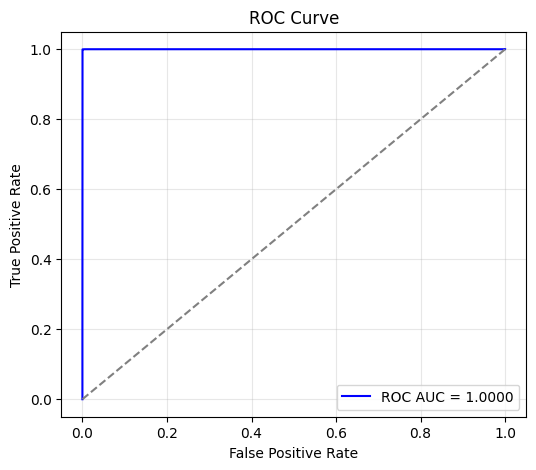

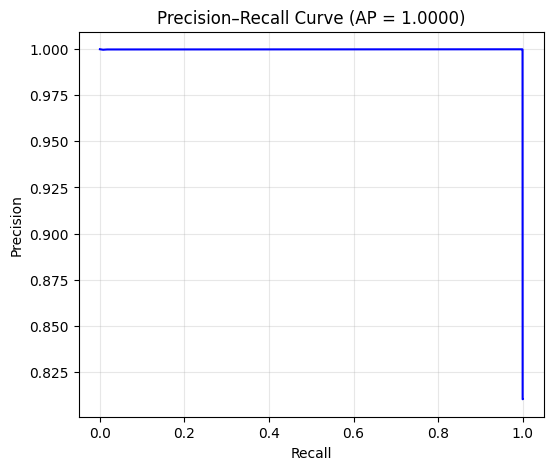

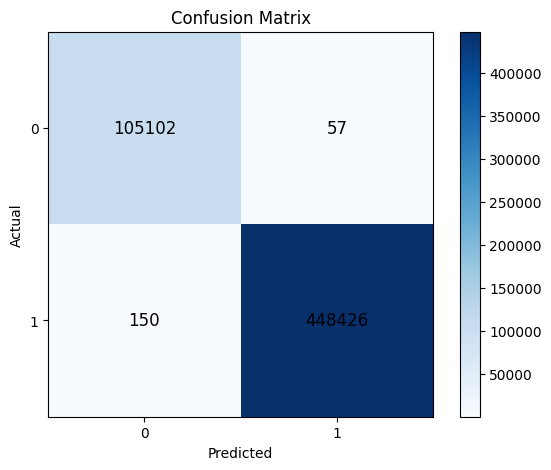

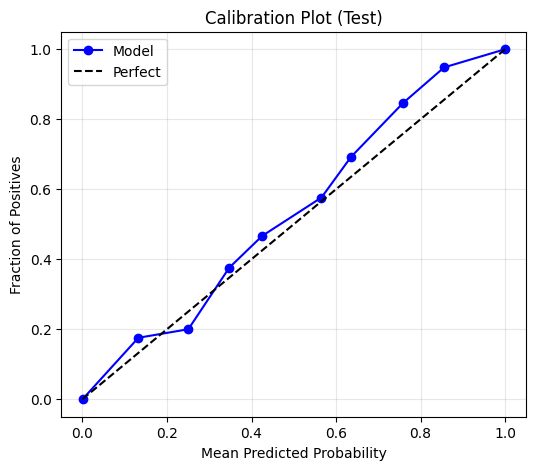

In [18]:
# === Cell 5: Evaluasi Visual Lengkap untuk LightGBM ===

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, 
    precision_recall_curve, average_precision_score,
    confusion_matrix
)
from sklearn.calibration import calibration_curve
import numpy as np

# ---------------- ROC Curve ----------------
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# ---------------- Precision–Recall Curve ----------------
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color="blue")
plt.title(f"Precision–Recall Curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.3)
plt.show()


# ---------------- Confusion Matrix (Blue–White) ----------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

# Labeling
classes = [0, 1]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Tulisan angka
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="black", fontsize=12)

plt.show()


# ---------------- Calibration Plot ----------------
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="Model", color="blue")
plt.plot([0,1], [0,1], "--", color="black", label="Perfect")
plt.title("Calibration Plot (Test)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [5]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [6]:
# === Cell 5: Siapkan data distillation ===

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Target: probabilitas dari LightGBM
train_probs = lgbm.predict_proba(X_train)[:, 1]
val_probs = lgbm.predict_proba(X_val)[:, 1]

print(f"Train probs shape: {train_probs.shape}, Val probs shape: {val_probs.shape}")


Train probs shape: (1771951,), Val probs shape: (442988,)


In [10]:
# === Cell 6: Train student model (Distillation Stabil & Akurat) ===

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
import tensorflow as tf
import numpy as np

# Data float32
X_train_np = X_train.astype("float32").to_numpy()
X_val_np = X_val.astype("float32").to_numpy()
y_train_soft = train_probs.astype("float32")
y_val_soft = val_probs.astype("float32")

# Temperatur scaling untuk melunakkan label
T = 2.5
y_train_soft_T = np.clip(y_train_soft, 1e-6, 1-1e-6) ** (1/T)
y_val_soft_T = np.clip(y_val_soft, 1e-6, 1-1e-6) ** (1/T)

# Model student (lebih stabil & dalam sedikit)
student = Sequential([
    Input(shape=(X_train_np.shape[1],), dtype="float32"),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error'  # cocok untuk meniru probabilitas teacher
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint("student_best.keras", save_best_only=True, monitor='val_loss', verbose=1)
]

history = student.fit(
    X_train_np, y_train_soft_T,
    validation_data=(X_val_np, y_val_soft_T),
    batch_size=4096,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

print("✅ Training selesai. Model disimpan ke student_best.keras")


Epoch 1/50
432/433 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1090
Epoch 1: val_loss improved from None to 0.06313, saving model to student_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0852 - val_loss: 0.0631 - learning_rate: 0.0010
Epoch 2/50
428/433 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0659
Epoch 2: val_loss improved from 0.06313 to 0.06067, saving model to student_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0644 - val_loss: 0.0607 - learning_rate: 0.0010
Epoch 3/50
428/433 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0623
Epoch 3: val_loss improved from 0.06067 to 0.06027, saving model to student_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0619 - val_loss: 0.0603 - learning_rate: 0.0010
Epoch 4/50
429/433 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0612
Epoch 4: val_loss improved from 0.06027 to 0.05891, saving model to student_best.keras
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0606 - val_loss: 0.0589 - learning

In [11]:
# === Cell 7: Evaluasi student vs teacher ===
y_student_prob = student.predict(X_test.astype("float32"), batch_size=2048).squeeze()
y_student_pred = (y_student_prob > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_student_prob))
print("\nClassification Report:\n", classification_report(y_test, y_student_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_student_pred))


271/271 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ROC-AUC: 0.9352536572390898

Classification Report:
               precision    recall  f1-score   support

           0     0.7858    0.9639    0.8658    105159
           1     0.9911    0.9384    0.9640    448576

    accuracy                         0.9433    553735
   macro avg     0.8885    0.9512    0.9149    553735
weighted avg     0.9521    0.9433    0.9454    553735


Confusion Matrix:
 [[101363   3796]
 [ 27624 420952]]


In [4]:
import sys
path = sys.executable
!"{path}" -m pip install matplotlib


     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
      --------------------------------------- 0.1/8.1 MB 3.3 MB/s eta 0:00:03
     - -------------------------------------- 0.3/8.1 MB 5.2 MB/s eta 0:00:02
     --- ------------------------------------ 0.6/8.1 MB 5.7 MB/s eta 0:00:02
     ---- ----------------------------------- 1.0/8.1 MB 6.4 MB/s eta 0:00:02
     ------ --------------------------------- 1.2/8.1 MB 6.1 MB/s eta 0:00:02
     ------- -------------------------------- 1.5/8.1 MB 6.1 MB/s eta 0:00:02
     -------- ------------------------------- 1.7/8.1 MB 5.8 MB/s eta 0:00:02
     ---------- ----------------------------- 2.1/8.1 MB 6.0 MB/s eta 0:00:01
     ----------- ---------------------------- 2.2/8.1 MB 5.9 MB/s eta 0:00:01
     ------------ --------------------------- 2.6/8.1 MB 6.1 MB/s eta 0:00:01
     -------------- ------------------------- 2.9/8.1 MB 6.1 MB/s eta 0:00:01
     --------------- ------------------------ 3.1/8.1 MB 6.2 MB/s eta 0


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


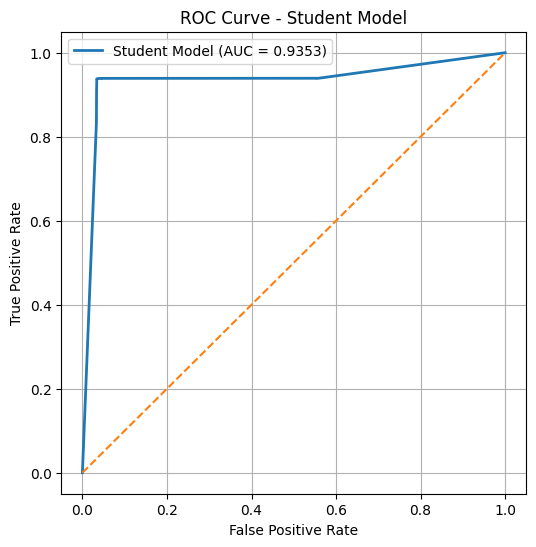

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Hitung ROC curve student model
fpr, tpr, thresholds = roc_curve(y_test, y_student_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linewidth=2, label=f"Student Model (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')

plt.title("ROC Curve - Student Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


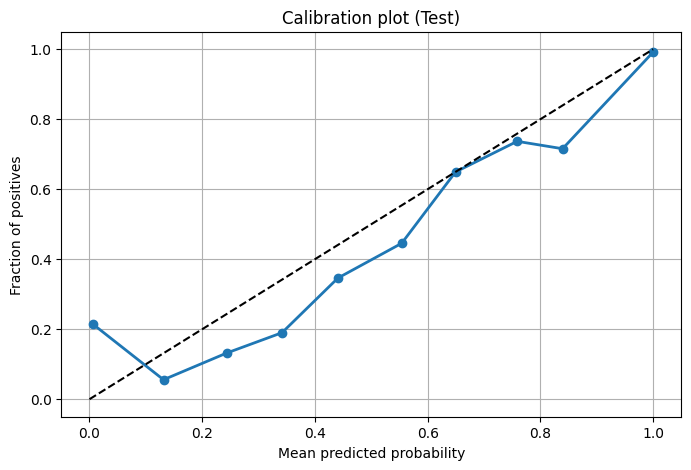

In [13]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_test      → label asli
# y_student_prob → probabilitas prediksi (0–1)

prob_true, prob_pred = calibration_curve(y_test, y_student_prob, n_bins=10)

plt.figure(figsize=(8, 5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2)
plt.plot([0, 1], [0, 1], "--", color="black")

plt.title("Calibration plot (Test)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.grid(True)
plt.show()


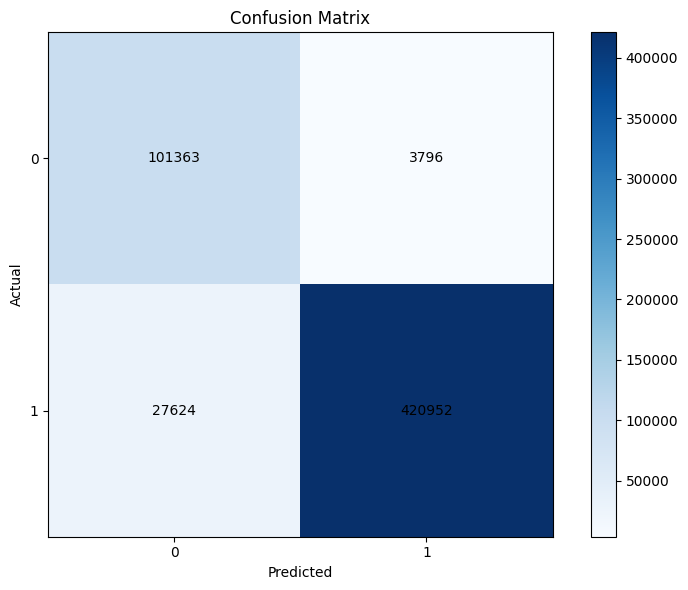

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_student_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

classes = ["0", "1"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Tampilkan angka
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="black")

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


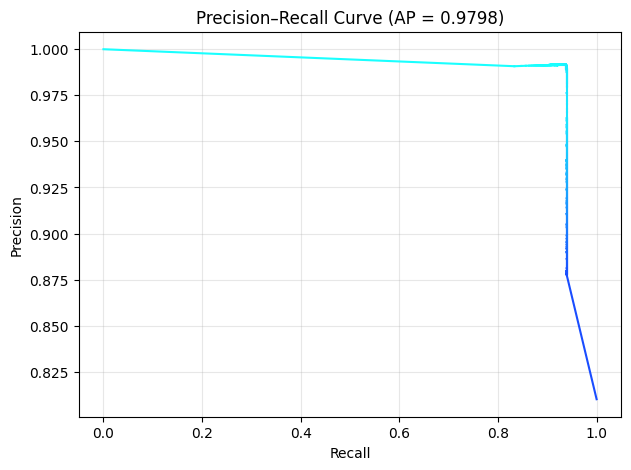

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# y_test = label aktual
# y_student_prob = probabilitas prediksi model (contoh: model.predict_proba(X_test)[:,1])

# Hitung precision, recall
precision, recall, thresholds = precision_recall_curve(y_test, y_student_prob)
ap = average_precision_score(y_test, y_student_prob)

# ---------- Plot Precision–Recall Curve ----------
plt.figure(figsize=(7,5))

# Gradasi biru-putih manual
for i in range(len(recall)-1):
    plt.plot(recall[i:i+2], precision[i:i+2],
             color=(0.1, 0.3 + 0.7*(i/len(recall)), 1.0))  # biru → putih

plt.title(f"Precision–Recall Curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(alpha=0.3)

plt.show()


In [19]:
from tensorflow.keras.models import load_model
import os

# === Pengaturan ===
old_model_path = "student_best.keras"          # model lama hasil training
new_model_dir  = "../models"                   # folder tujuan (sudah kamu buat di GitHub)
new_model_name = "lgbm_student.keras" # nama baru model

# === Buat folder kalau belum ada ===
os.makedirs(new_model_dir, exist_ok=True)

# === Load model lama ===
model = load_model(old_model_path)

# === Simpan ulang ke folder baru ===
new_model_path = os.path.join(new_model_dir, new_model_name)
model.save(new_model_path)

print(f"✅ Model berhasil disimpan ke: {new_model_path}")


✅ Model berhasil disimpan ke: ../models\lgbm_student.keras


In [20]:
import tensorflow as tf

# Load model hasil training
model = tf.keras.models.load_model("../models/lgbm_student.keras")

# Konversi ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Opsional) optimasi ukuran file agar ringan di deployment
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Jalankan konversi
tflite_model = converter.convert()

# Simpan hasil konversi ke folder yang sama
with open("../models/lgbm_student.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke format TFLite: ../models/lgbm_student.tflite")


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpxy6gyykz\assets


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmpxy6gyykz\assets


Saved artifact at 'C:\Users\BINTAN~1\AppData\Local\Temp\tmpxy6gyykz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2214486459488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2214486170208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2214486500880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2214486496832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2214486500704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2214486506688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2214484119744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2214484120448: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model berhasil dikonversi ke format TFLite: ../models/lgbm_student.tflite


In [21]:
# Verifikasi arsitektur model TFLite
interpreter = tf.lite.Interpreter(model_path="../models/lgbm_student.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("=== Input Tensor ===")
print(input_details)
print("\n=== Output Tensor ===")
print(output_details)


=== Input Tensor ===
[{'name': 'serving_default_input_layer_2:0', 'index': 0, 'shape': array([ 1, 30], dtype=int32), 'shape_signature': array([-1, 30], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

=== Output Tensor ===
[{'name': 'StatefulPartitionedCall_1:0', 'index': 13, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


c:\Users\BINTANG PANDU\IPS+ML\CICIDS2017---IPSML\venv310\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [22]:
import numpy as np
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="../models/lgbm_student.tflite")
interpreter.allocate_tensors()

# Ambil detail tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Buat dummy data (1 sampel, 30 fitur)
dummy_input = np.random.rand(1, 30).astype(np.float32)

# Jalankan inferensi
interpreter.set_tensor(input_details[0]['index'], dummy_input)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])

print("Output prediksi:", prediction)


Output prediksi: [[1.]]
